<a href="https://colab.research.google.com/github/hatopopvr/MyBeatSaberAnalytics/blob/main/MyBeatSaberAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Readme

### 概要
BeatSaberのScoreSaberの情報を取得し、Rank譜面Clearの進捗状況や、Play傾向を散布図で分析するツールです。

本ツールは [Satoさん](https://twitter.com/zitasato) の [MyBeatSaberScore](https://github.com/tkns3/MyBeatSaberScore/) に影響を受け、クリア進捗やスコア傾向をグラフ等で可視化するために作成しました。  本ツールには未クリア譜面の詳細検索や未クリア譜面のプレイリスト作成機能などは含まれません。

### 使用方法

以下ツイートの動画に使い方まとめていますので、参照ください。

<blockquote class="twitter-tweet"><p lang="ja" dir="ltr">BeatSaberのScoreSaberのデータを使ってRank譜面のクリア進捗とか可視化するツール<br>概ね作りたかった機能が作り終わったので公開↓<a href="https://t.co/Roifdz8jvU">https://t.co/Roifdz8jvU</a><br><br>基本自分用かつサバ運用費や環境構築を割愛するとか諸々の都合でGoogle Colabで作ってるので使い方は以下動画参考。 <a href="https://t.co/k4WfVcpJhd">pic.twitter.com/k4WfVcpJhd</a></p>&mdash; はとぽぷ3.0 (@hatopop_vr) <a href="https://twitter.com/hatopop_vr/status/1516453029394149376?ref_src=twsrc%5Etfw">April 19, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

本notebookをGoogle Colobで起動してください。
入力情報のフォームに必要事項を入力し、ランタイムでセルを実行してください。
セルを実行していただくと、Google Driveにマウントし、曲情報やPlay情報などをGoogle Driveの指定フォルダに保存します。
プレイ情報と曲情報の取得・解析には時間がかかります。

Rank譜面のClearの進捗状況や、SS/S/AなどのScoreのランクの状況を可視化できます。

<img src="https://pbs.twimg.com/media/FPBJ8_xacAU9rNA?format=jpg" />

条件を選択し散布図で分析できます。

<img src="https://pbs.twimg.com/media/FO8HJb1agAcVvn5?format=jpg" />


### 使用データ
本ツールは以下のデータを利用しています。
- ScoreSaberのPublic API - [doc](https://docs.scoresaber.com/)  
　Player情報 - https://scoresaber.com/api/player/{player_id}/full  
　Score情報 - https://scoresaber.com/api/player/{player_id}/scores?sort=recent&page={page}  
- 画像データ  
　Player画像 - https://cdn.scoresaber.com/avatars/{player_id}.jpg  
　Cover画像 - https://cdn.scoresaber.com/covers/{hash}.png  
- 曲情報  
  暫定的ですがandruzzzhkaさんがgithubで公開している[
BeatSaberScrappedData](https://github.com/andruzzzhka/BeatSaberScrappedData) を利用しています。

### 使用ライブラリ

本ツールは多数のOSSのLibraryに依存しています。
使用項目については Libraryの取得 を参照願います。

### 問い合わせ先

twitter:[@hatopop_vr](https://twitter.com/hatopop_vr)

### 使用ライブラリ

In [ ]:
!pip install GitPython
!pip install -U hiplot

In [ ]:
#@title Libraryの取得
import warnings
warnings.filterwarnings("ignore")
import os
import shutil
import pandas as pd
from pandas import json_normalize
import json
from datetime import datetime
from dateutil import tz
#import matplotlib
#import seaborn as sns
import plotly.express as px
from ipywidgets import interact, Select, BoundedIntText, IntSlider, ToggleButtons, Layout, HBox, VBox, AppLayout
import time
from tqdm import tqdm
import requests
import math
import git
import gc
import hiplot as hip
from IPython.display import HTML
from google.colab import drive, files


# 入力情報

## 入力変数
- player_id: ScoreSaberのPlayerIDです。  
- google_drive_mount_path: GoogleDriveのマウント先です。変更不要。  
- google_drive_dir_path: GoogleDrive内の保存先です。必要に応じて変更してください。  
- song_data_zip_git_url: ScoreSaberの全曲情報のzip(json)のURLです。変更なければそのままで。  
- latest:Latest Historyで表示する対象の日数です。0なら現在から24時間以内。  
- saved_song_list_is_enable:解析済の曲情報を使用するか。☑で使用。※新規取得は数十分要。
- saved_player_score_is_enable:
解析済のプレイ情報を使用するか。☑で使用。※処理時間は総PlayCountに依存。  

In [ ]:
#@title 変数概要を参照し、以下のデータを入力してください。 { display-mode: "form" }
player_id =  76561198412839195#@param {type:"number"}
google_drive_mount_path = "/content/drive" #@param {type:"string"}
google_drive_dir_path = "/MyDrive/MyBeatSaberAnalysis/data" #@param {type:"string"}
song_data_zip_git_url = "https://github.com/andruzzzhka/BeatSaberScrappedData.git" #@param {type:"string"}
latest =  -1#@param {type:"integer"}
saved_song_list_is_enable = True #@param {type:"boolean"}
saved_player_score_is_enable = False #@param {type:"boolean"}

In [ ]:
#@title Google Driveのマウント
drive.mount(google_drive_mount_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title その他設定値
data_path = r"{}{}".format(google_drive_mount_path, google_drive_dir_path)
player_info_path = r"{}/player_info_{}.csv".format(data_path, player_id)
player_score_path = r"{}/scores_full_{}.csv".format(data_path, player_id)
player_ranked_path = r"{}/scores_ranked_{}.csv".format(data_path, player_id)
song_clone_path = r"/content/BeatSaberScrappedData"
song_zip_path = r"{}/combinedScrappedData.zip".format(song_clone_path)
song_json_path = r"{}/combinedScrappedData.json".format(data_path)
song_list_path = r"{}/song_list_full.csv".format(data_path)
song_ranked_path = r"{}/song_ranked.csv".format(data_path)
song_playlist_path = r"{}/playlist_{}.json".format(data_path, datetime.now().strftime("%Y%m%d"))
level_cleared_path = r"{}/level_cleared_{}.csv".format(data_path, player_id)
pd.options.display.precision = 2
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
page_count=8 #ScoreSaberの1ページあたりのページ数
image_size=70 #カバー,プロファイル画像のサイズ単位px
os.makedirs(data_path, exist_ok=True)

In [ ]:
#@title 列情報の設定
cols_info =[
    "Pic"
    ,"name"
    ,"country"
    ,"pp"
    ,"rank"
    ,"countryRank"
    ,"role"
    ,"TotalScore"
    ,"RankedScore"
    ,"AveRankedAcc"
    ,"TotalPlay"
    ,"RankedPlay"
    ,"ReplayWatched"
    ,"ScoreDate"
]

# SongList抜粋用列
cols_song =[
    "Cover"
    ,"Song"
    ,"Level"
    ,"LevelStr"
    ,"Stars"
    # ,"maxPP"
    # ,"maxScore"
    ,"Difficulty"
    # ,"Play"
    # ,"DailyPlay"
    ,"CreatedDateJa"
    ,"RankDateJa"
    ,"Bombs"
    ,"Notes"
    ,"Obstacles"
    ,"Njs"
    ,"NjsOffset"
    ,"Bpm"
    ,"Upvotes"
    #,"Downvotes"
    ,"Duration"
    ,"Ranked"
]
# Score用列
cols_score =[
    "Cover"
    ,"Song"
    ,"Level"
    ,"Stars"
    ,"Acc"
    ,"AccRank"
    ,"FC"
    ,"Rank"
    ,"PP"
    ,"Miss"
    ,"Bad"
    ,"Combo"
    ,"Score"
    ,"Mode"
    ,"Difficulty"
    ,"Play"
    ,"DailyPlay"
    ,"Bpm"
    ,"Duration"
    ,"Notes"
    ,"Njs"
    ,"Bombs"
    ,"Obstacles"
    ,"NjsOffset"
    ,"Upvotes"
    ,"Downvotes"
    ,"Ranked"
    ,"Days"
    ,"Months"
 ]

# ScatterPlot用X-Y軸列
cols_xy = [
    "Stars"
    ,"Acc"
    ,"Rank"
    ,"PP"
    ,"Miss"
    ,"Bad"
    ,"Combo"
    ,"Score"
    ,"Play"
    ,"DailyPlay"
    ,"Days"
    ,"Months"
    ,"Bpm"
    ,"Duration"
    ,"Notes"
    ,"Njs"
    ,"Bombs"
    ,"Obstacles"
    ,"NjsOffset"
    ,"Upvotes"
    ,"Downvotes"
]

# ScatterPlot用カテゴリ
cols_cate = [
    "LevelStr"
    ,"Days"
    ,"DaysStr"
    ,"Months"
    ,"MonthsStr"
    ,"LatestStr"
    ,"Acc"
    ,"AccRank"
]

# Worst-Top ScatterPlot用カテゴリ
cols_cate_wt = [
    "WorstTop"
    ,"LevelStr"
    ,"Days"
    ,"DaysStr"
    ,"Months"
    ,"MonthsStr"
    ,"LatestStr"
    ,"Acc"
    ,"AccRank"
]

# データの取得

## Get Player Info (df_info)

In [ ]:
#@title Player情報の取得
url = r"https://scoresaber.com/api/player/{}/full".format(player_id)
response = requests.get(url)
res_data = response.json()
df_info = json_normalize(res_data)

df_info["Pic"] = '<img src="'+df_info["profilePicture"]+'"/>'
df_info["TotalScore"] = df_info["scoreStats.totalScore"]
df_info["RankedScore"] = df_info["scoreStats.totalRankedScore"]
df_info["AveRankedAcc"] = df_info["scoreStats.averageRankedAccuracy"]
df_info["TotalPlay"] = df_info["scoreStats.totalPlayCount"]
df_info["RankedPlay"] = df_info["scoreStats.rankedPlayCount"]
df_info["ReplayWatched"] = df_info["scoreStats.replaysWatched"]
df_info["ScoreDate"] = datetime.now().strftime("%Y/%m/%d %H:%M:%S")

# cols_info =[
#     "Pic"
#     ,"name"
#     ,"country"
#     ,"pp"
#     ,"rank"
#     ,"role"
#     ,"TotalScore"
#     ,"RankedScore"
#     ,"AveRankedAcc"
#     ,"TotalPlay"
#     ,"RankedPlay"
#     ,"ReplayWatched"
#     ,"ScoreDate"
# ]

PlayCount = df_info["TotalPlay"][0]
RangeCount = math.ceil(PlayCount / page_count) + 1

#@title Player情報の記録
if os.path.exists(player_info_path):
    df_info[cols_info].to_csv(player_info_path, mode="a", index=None, header=False)
else:
    df_info[cols_info].to_csv(player_info_path, index=None)

df_infos = pd.read_csv(player_info_path)
df_infos["ScoreDate"] = pd.to_datetime(df_infos["ScoreDate"])

print("Play数:{}, Page数:{}".format(PlayCount, RangeCount))

Play数:1185, Page数:150


In [ ]:
#@title Player Info
styles = [
    dict(selector="td", props=[("font-size", "130%"),
                               ("text-align", "center")])
]

df_info[cols_info].style.set_table_styles(styles).highlight_null(null_color="lightgray").set_precision(2)


,Pic,name,country,pp,rank,countryRank,role,TotalScore,RankedScore,AveRankedAcc,TotalPlay,RankedPlay,ReplayWatched,ScoreDate
0,,hatopop,JP,6050.65,4592,291,None,791705561,769888920,85.84,1185,1147,0,2022/04/21 08:51:37


In [ ]:
#@title Player Summary
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=6, cols=1,
    subplot_titles=("Global Rank", "{} Rank".format(df_info["country"][0]), "Total PP", "Average Ranked Acc", "Total Play Count", "Ranked Play Count"))


fig.add_trace(go.Scatter(x=df_infos["ScoreDate"], y=df_infos["rank"], name="Rank"),row=1,col=1)
fig.add_trace(go.Scatter(x=df_infos["ScoreDate"], y=df_infos["countryRank"], name="{}-Rank".format(df_info["country"][0])), row=2, col=1)
fig.add_trace(go.Scatter(x=df_infos["ScoreDate"], y=df_infos["pp"], name="PP"),row=3,col=1)
fig.add_trace(go.Scatter(x=df_infos["ScoreDate"], y=df_infos["AveRankedAcc"], name="Acc"),row=4,col=1)
fig.add_trace(go.Scatter(x=df_infos["ScoreDate"], y=df_infos["TotalPlay"], name="TotalPlay"),row=5,col=1)
fig.add_trace(go.Scatter(x=df_infos["ScoreDate"], y=df_infos["RankedPlay"], name="RankedPlay"),row=6,col=1)

fig.update_layout(barmode="relative", title_text="Player Summary - {} - {}".format(datetime.now().strftime("%Y.%m.%d"), df_info["name"][0]),
                  width=1000, height=800,
                  hovermode="x unified")
fig.show()

## Get Song List (df_songs, df_ranked_songs)

In [ ]:
#@title Song Listを取得し展開(最新取得は30分程度かかる可能性あり)
if saved_song_list_is_enable and os.path.exists(song_list_path):
    df_songs = pd.read_csv(song_list_path)
    df_ranked_songs = df_songs[
                    (1==1)
                    &(df_songs['Ranked'])
                    &(df_songs['Mode'] == 'Standard')
                    ].drop('index', axis=1).drop_duplicates()

else:
    # GithubからZipのダウンロード
    if os.path.exists(song_clone_path):
        shutil.rmtree(song_clone_path)

    git.Git().clone(song_data_zip_git_url)

    # Zipの解凍
    shutil.unpack_archive(song_zip_path, data_path)

    # 
    json_open = open(song_json_path,"r", encoding="utf-8")
    json_load = json.load(json_open)
    _df_songs_from_json = json_normalize(json_load)

    cnt=0

    _df_song_from_json = _df_songs_from_json.loc[0]

    # jsonの入れ子のDiffsの内容を展開
    _df_song = json_normalize(_df_song_from_json["Diffs"])
    _df_song["Bsr"]=_df_song_from_json["Key"]
    _df_song["Hash"]=_df_song_from_json["Hash"]
    _df_song["SongName"]=_df_song_from_json["SongName"]
    _df_song["SongSub"]=_df_song_from_json["SongSubName"]
    _df_song["SongAuthor"]=_df_song_from_json["SongAuthorName"]
    _df_song["LevelAuthor"]=_df_song_from_json["LevelAuthorName"]
    #_df_song["Chars"]=_df_song_from_json["Chars"][0]
    _df_song["Uploaded"]=_df_song_from_json["Uploaded"]
    _df_song["Uploader"]=_df_song_from_json["Uploader"]
    _df_song["Bpm"]=_df_song_from_json["Bpm"]
    _df_song["Upvotes"]=_df_song_from_json["Upvotes"]
    _df_song["Downvotes"]=_df_song_from_json["Downvotes"]
    _df_song["Duration"]=_df_song_from_json["Duration"]

    # headerの作成
    df_songs = _df_song

    for idx in tqdm(range(len(_df_songs_from_json))):

        if cnt == 0:
            cnt+=1
            pass
        cnt+=1
        # jsonの入れ子のDiffsの内容を展開
        _df_song = json_normalize(_df_songs_from_json.loc[idx]["Diffs"])
        _df_song["Bsr"]=_df_songs_from_json.loc[idx]["Key"]
        _df_song["Hash"]=_df_songs_from_json.loc[idx]["Hash"]
        _df_song["SongName"]=_df_songs_from_json.loc[idx]["SongName"]
        _df_song["SongSub"]=_df_songs_from_json.loc[idx]["SongSubName"]
        _df_song["SongAuthor"]=_df_songs_from_json.loc[idx]["SongAuthorName"]
        _df_song["LevelAuthor"]=_df_songs_from_json.loc[idx]["LevelAuthorName"]
        #_df_song["Chars"]=_df_songs_from_json.loc[idx]["Chars"][0]
        _df_song["Uploaded"]=_df_songs_from_json.loc[idx]["Uploaded"]
        _df_song["Uploader"]=_df_songs_from_json.loc[idx]["Uploader"]
        _df_song["Bpm"]=_df_songs_from_json.loc[idx]["Bpm"]
        _df_song["Upvotes"]=_df_songs_from_json.loc[idx]["Upvotes"]
        _df_song["Downvotes"]=_df_songs_from_json.loc[idx]["Downvotes"]
        _df_song["Duration"]=_df_songs_from_json.loc[idx]["Duration"]
        df_songs = df_songs.append(_df_song, ignore_index=True)

    # 欲しい形に加工
    #df_songs["Song"] = df_songs["SongName"] + " " + df_songs["SongSubName"] + " / " + df_songs["SongAuthorName"] + " [" + df_songs["LevelAuthorName"] + "]"
    df_songs["Song"] = df_songs["SongName"] + " " + df_songs["SongSub"] + " / " + df_songs["SongAuthor"] + " [" + df_songs["LevelAuthor"] + "]"
    #df_songs["Difficulty"] = df_songs["Diff"]
    df_songs.rename(columns={
                            "Diff":"Difficulty",
                             "Char":"Mode"
                             }, inplace=True)
    #df_songs["Stars"] = df_songs["Stars"]
    df_songs["Level"] = df_songs["Stars"].astype("int")
    df_songs["LevelStr"] = df_songs["Level"].astype("str")
    df_songs["Cover"] = '<img src="https://cdn.scoresaber.com/covers/' + df_songs["Hash"] + '.png" style="width:{}px;"/>'.format(image_size)
    df_songs["RankDateUtc"] = pd.to_datetime(df_songs["RankedUpdateTime"])
    _df_songs_idx = df_songs.set_index("RankDateUtc")
    df_songs["RankDateJa"] = _df_songs_idx.index.tz_convert("Asia/Tokyo")
    df_songs = df_songs.set_index("RankDateJa")
    df_songs = df_songs.reset_index()
    df_songs["CreatedUtc"] = pd.to_datetime(df_songs["Uploaded"])
    _df_songs_idx = df_songs.set_index("CreatedUtc")
    df_songs["CreatedDateJa"] = _df_songs_idx.index.tz_convert("Asia/Tokyo")
    df_songs = df_songs.reset_index()
    
    # 改行コード等の除去
    for col in df_songs.columns:
        try:
            if len(df_songs[df_songs[col].str.contains("\n")][[col]]) == 0:
                continue
            else:
                df_songs[col] = df_songs[col].str.replace("\n","")
        except:
            continue

    for col in df_songs.columns:
        try:
            if len(df_songs[df_songs[col].str.contains("\r")][[col]]) == 0:
                continue
            else:
                df_songs[col] = df_songs[col].str.replace("\r","")
        except:
            continue

    # SongListの保存
    df_ranked_songs = df_songs[
                        (1==1)
                        &(df_songs['Ranked'])
                        &(df_songs['Mode'] == 'Standard')
                        ].drop('index', axis=1).drop_duplicates().count()
    df_ranked_songs.to_csv(song_ranked_path, index=False)

    #df_songs[df_songs["Ranked"]==1][cols_song].to_csv(song_ranked_path, index=False)
    # SongListの保存
    df_songs.to_csv(song_list_path, index=False)

print("Song:{}, RankedSong:{}".format(df_songs["Song"].count(), df_ranked_songs["Song"].count()))

Song:95384, RankedSong:2947


## Get Player Scores (df_scores)

In [ ]:
#@title Score情報の取得
if saved_player_score_is_enable and os.path.exists(player_score_path):    
    df_scores = pd.read_csv(player_score_path)

else:
    url = r"https://scoresaber.com/api/player/{}/scores?sort=recent".format(player_id)
    response = requests.get(url)
    res_data = response.json()
    df_scores = json_normalize(res_data['playerScores'])

    for i in tqdm(range(2, RangeCount)):
        url = r"https://scoresaber.com/api/player/{}/scores?sort=recent&page={}".format(player_id, i)
        try:
            response = requests.get(url)
            res_data = response.json()
            #df2 = json_normalize(res_data['playerScores'])
            df_scores=df_scores.append(json_normalize(res_data['playerScores']), ignore_index=True)
        except:
            break

    df_scores['Song'] = df_scores['leaderboard.songName'] + " " + df_scores['leaderboard.songSubName'] + " / " + df_scores['leaderboard.songAuthorName'] + " [" + df_scores['leaderboard.levelAuthorName'] + "]"
    df_scores['SongName'] = df_scores['leaderboard.songName']
    df_scores['SongSub'] = df_scores['leaderboard.songSubName']
    df_scores['SongAuthor'] = df_scores['leaderboard.songAuthorName']
    df_scores['LevelAuthor'] = df_scores['leaderboard.levelAuthorName']
    df_scores['Hash'] = df_scores['leaderboard.songHash']    
    df_scores['Acc'] = df_scores['score.modifiedScore'] / df_scores['leaderboard.maxScore'] * 100

    def func_mode(x):
        if  x == "SoloStandard":
            return "Standard"
        else:
            return x

    df_scores['Mode'] = df_scores['leaderboard.difficulty.gameMode'].apply(func_mode)
    #df_scores['Mode'] = df_scores['leaderboard.difficulty.gameMode']
    _df_scores = df_scores['leaderboard.difficulty.difficultyRaw'].str.split('_', expand=True)
    _df_scores.columns = ['_','Difficulty', 'Mode']
    df_scores['Difficulty'] = _df_scores['Difficulty']
    df_scores['Stars'] = df_scores['leaderboard.stars']
    df_scores['Level'] = df_scores['Stars'].astype('int')
    df_scores["LevelStr"] = df_scores['Level'].astype('str')
    df_scores['Score'] = df_scores['score.modifiedScore']
    df_scores['Bad'] = df_scores['score.badCuts']
    df_scores['Miss'] = df_scores['score.missedNotes']
    df_scores['Combo'] = df_scores['score.maxCombo']
    df_scores['PP'] = df_scores['score.pp']
    df_scores['PPWeight'] = df_scores['score.pp'] * df_scores['score.weight']
    df_scores['Rank'] = df_scores['score.rank']
    df_scores['Modifiers'] = df_scores['score.modifiers']
    df_scores['Ranked'] = df_scores['leaderboard.ranked']
    df_scores['Qualified'] = df_scores['leaderboard.qualified']
    df_scores['Play'] = df_scores['leaderboard.plays']
    df_scores['DailyPlay'] = df_scores['leaderboard.dailyPlays']
    df_scores['DateUtc'] = pd.to_datetime(df_scores['score.timeSet'])
    _df_scores_idx = df_scores.set_index('DateUtc')
    df_scores['DateJa'] = _df_scores_idx.index.tz_convert('Asia/Tokyo')
    df_scores = df_scores.set_index('DateJa')
    df_scores['Days'] = (pd.Timestamp(datetime.now(), tz='Asia/Tokyo') - df_scores.index).days
    df_scores['Months'] = (df_scores['Days'] / 30).astype('int')
    df_scores['DaysStr'] = df_scores['Days'].astype('str')
    df_scores['MonthsStr'] = df_scores['Months'].astype('str')
    def func_latest(x):
        if  x <= latest:
            return 1
        else:
            return 0

    df_scores['Latest'] = df_scores['Days'].apply(func_latest)
    
    def func_score(x):
        if  x == 100:
            return "SSS"
        elif x >= 90:
            return "SS"
        elif x >= 80:
            return "S"
        elif x >= 65:
            return "A"
        elif x >= 50:
            return "B"
        elif x >= 35:
            return "C"
        elif x >= 20:
            return "D"
        elif x >= 0:
            return "E"
        else:
            return "-"

    df_scores['AccRank'] = df_scores['Acc'].apply(func_score)
  
    df_scores['Cover'] = '<img src="'+df_scores['leaderboard.coverImage']+'" style="width:{}px;"/>'.format(image_size)

    def func_fc(x):
        if  x:
            return "FC"
        else:
            return "-"

    df_scores['FC'] = df_scores['score.fullCombo'].apply(func_fc)

    df_scores = df_scores[[x for x in df_scores.columns if not x.startswith("score.")]]
    df_scores = df_scores[[x for x in df_scores.columns if not x.startswith("leaderboard.")]]

    df_scores_org = df_scores.copy()
    df_scores = df_scores.reset_index()
    df_scores = pd.merge(df_scores, df_songs, on=["Hash", "Difficulty","Mode"], how="inner", suffixes=("", "_y"))
    df_scores = df_scores[[x for x in df_scores.columns if not x.endswith("_y")]]
    df_scores = df_scores.set_index("DateJa")
    # df_scores.to_csv("scores_{}.csv".format(datetime.now().strftime("%Y%m%d")))
    # df_merges.to_csv("merges_{}.csv".format(datetime.now().strftime("%Y%m%d")))
    # df_scores_org = df_scores.copy()
    # df_scores = df_merges

    #Score情報の保存
    df_scores[(df_scores['Ranked'] == True)][cols_score].sort_index(ascending=False).to_csv(player_ranked_path)
    df_scores.sort_index(ascending=False).to_csv(player_score_path.format(player_id))

print('ScoreCount:{}, LatestPlayCount:{}'.format(df_scores['Play'].count(), df_scores[(df_scores['Latest'] == 1)]['Play'].count()))

100%|██████████| 148/148 [00:59<00:00,  2.48it/s]


ScoreCount:1174, LatestPlayCount:0


## Ranked - Calc Level Cleared Progress (df_progress) 

### データについての捕捉  

__データについての捕捉__

- 分母であるRank譜面の曲数について  
取得した曲データから"Ranked"==True かつ "Mode"=="Standard"でユニークなデータを計上しています。  
<"Standard"のみの採用理由>  
[ScoreSaber Ranking Criteria](https://docs.google.com/document/d/1_EBmvCTHyJ5-0ox5IZgmnItVqAjaBWltWslxqSc5_-4/edit#heading=h.11dlgmbqgxsa)のRules 1.Gameplay の記述(以下)に基づいています。
> Maps must be ‘Standard’ game mode maps.   

- クリア数 Cleared Count について  
ScoreSaberで集計される Ranked Play Count についてはNoFailでのクリアも数値に計上されますが、本ツールでは NoFail でのクリアを区別し、クリア数 Cleared Countに含みません。NoFailで進捗率100%が埋まるのはツール作成者の本意ではないためです。そのため、数値が ScoreSaberのRanked Play Countと一致しない旨をご了承ください。  

__謝辞__

本ツールでの曲数計上の整合性について [HPC](https://twitter.com/HPC______)さん、[sato](https://twitter.com/zitasato)さんに協力頂きました。感謝。 

### 結合処理

In [ ]:
#@title Level別 Clear 情報の結合
df_progress = df_ranked_songs[["Level","Song"]].groupby(["Level"],as_index=False).count()

# Level別Clear数(No Fail除く)
df_cleared = df_scores_org[(1==1)
                &(df_scores_org["Modifiers"] != "NF")
                & (df_scores_org["Ranked"] == True)
                ][["Level","Song"]].groupby(["Level"],as_index=False).count().rename(columns={"Song": "Cleared"})
# Level別 No fail数
df_cleared_nf = df_scores_org[(1==1)
                &(df_scores_org["Modifiers"] == "NF")
                & (df_scores_org["Ranked"] == True)
                ][["Level","Song"]].groupby(["Level"],as_index=False).count().rename(columns={"Song": "NF"})

# 直近のLevel別Clear数(No Fail除く)
df_cleared_latest = df_scores_org[(1==1)
                       &(df_scores_org["Modifiers"] != "NF")
                       & (df_scores_org['Ranked'] == True)
                       & (df_scores_org["Latest"] == 1)
                ][["Level","Song"]].groupby(["Level"],as_index=False).count().rename(columns={"Song": "RecentCleared"})

# 結合
df_progress = pd.merge(df_progress, df_cleared_latest, on="Level", how="outer")
df_progress = pd.merge(df_progress, df_cleared, on="Level", how="outer")
df_progress = pd.merge(df_progress, df_cleared_nf, on="Level", how="outer")

df_progress["NotCleared"] = df_progress["Song"].fillna(0) - df_progress["Cleared"].fillna(0) - df_progress["NF"].fillna(0)
df_progress["AlreadyCleared"] = df_progress["Cleared"].fillna(0) - df_progress["RecentCleared"].fillna(0)
df_progress = df_progress.fillna(0)
df_progress["NotClearedRate"] = df_progress["NotCleared"] / df_progress["Song"] * 100
df_progress["AlreadyClearedRate"] = df_progress["AlreadyCleared"] / df_progress["Song"] * 100
df_progress["RecentClearedRate"] = df_progress["RecentCleared"] / df_progress["Song"] * 100
df_progress["NFRate"] = df_progress["NF"] / df_progress["Song"] * 100


# Accの内訳
df_acc =df_scores_org[(1==1)
                &(df_scores_org["Modifiers"] != "NF")
                & (df_scores_org['Ranked'] == True)
                ].pivot_table(index="Level", columns= "AccRank", values="Song", aggfunc="count").fillna(0).reset_index()

cols_accs = ["SSS","SS","S","A","B"]

for cols_acc in cols_accs:
    if cols_acc in df_acc.columns :
        pass
    else:
        print("Rank{}データ無し".format(cols_acc))
        df_acc[cols_acc] = 0

df_progress = pd.merge(df_progress, df_acc, on="Level", how="outer").fillna(0)

df_progress["Other"] = df_progress["Song"] - df_progress["SSS"] - df_progress["SS"] - df_progress["S"] - df_progress["A"] - df_progress["B"]
df_progress["SSS-Rate"] = df_progress["SSS"] / df_progress["Song"] * 100
df_progress["SS-Rate"] = df_progress["SS"] / df_progress["Song"] * 100
df_progress["S-Rate"] = df_progress["S"] / df_progress["Song"] * 100
df_progress["A-Rate"] = df_progress["A"] / df_progress["Song"] * 100
df_progress["B-Rate"] = df_progress["B"] / df_progress["Song"] * 100
df_progress["Other-Rate"] = df_progress["Other"] / df_progress["Song"] * 100

df_progress.to_csv(level_cleared_path, index=False)

RankSSSデータ無し


In [ ]:
#@title clear情報 df_progress 内訳
df_progress.style.highlight_null(null_color="lightgray").set_precision(2)

,Level,Song,RecentCleared,Cleared,NF,NotCleared,AlreadyCleared,NotClearedRate,AlreadyClearedRate,RecentClearedRate,NFRate,A,B,S,SS,SSS,Other,SSS-Rate,SS-Rate,S-Rate,A-Rate,B-Rate,Other-Rate
0,0,27,0.00,27.00,0.00,0.00,27.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,27.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00
1,1,526,0.00,270.00,0.00,256.00,270.00,48.67,51.33,0.00,0.00,0.00,0.00,0.00,270.00,0.00,256.00,0.00,51.33,0.00,0.00,0.00,48.67
2,2,499,0.00,132.00,0.00,367.00,132.00,73.55,26.45,0.00,0.00,0.00,0.00,0.00,132.00,0.00,367.00,0.00,26.45,0.00,0.00,0.00,73.55
3,3,323,0.00,67.00,0.00,256.00,67.00,79.26,20.74,0.00,0.00,0.00,0.00,0.00,67.00,0.00,256.00,0.00,20.74,0.00,0.00,0.00,79.26
4,4,229,0.00,57.00,0.00,172.00,57.00,75.11,24.89,0.00,0.00,0.00,0.00,3.00,54.00,0.00,172.00,0.00,23.58,1.31,0.00,0.00,75.11
5,5,191,0.00,75.00,0.00,116.00,75.00,60.73,39.27,0.00,0.00,0.00,0.00,38.00,37.00,0.00,116.00,0.00,19.37,19.90,0.00,0.00,60.73
6,6,197,0.00,111.00,0.00,86.00,111.00,43.65,56.35,0.00,0.00,16.00,0.00,82.00,13.00,0.00,86.00,0.00,6.60,41.62,8.12,0.00,43.65
7,7,250,0.00,140.00,3.00,107.00,140.00,42.80,56.00,0.00,1.20,62.00,1.00,74.00,3.00,0.00,110.00,0.00,1.20,29.60,24.80,0.40,44.00
8,8,228,0.00,129.00,22.00,77.00,129.00,33.77,56.58,0.00,9.65,104.00,8.00,17.00,0.00,0.00,99.00,0.00,0.00,7.46,45.61,3.51,43.42
9,9,190,0.00,54.00,35.00,101.00,54.00,53.16,28.42,0.00,18.42,49.00,4.00,1.00,0.00,0.00,136.00,0.00,0.00,0.53,25.79,2.11,71.58


# 分析 可視化

## Ranked - Latest History / Parallel Coordinates Analysis - HiPlot (df_history)
※現在取得結果が0件の場合エラーが発生する不具合があります。  
　エラーが発生する場合はフィルターの条件を緩和して再度実行してください。


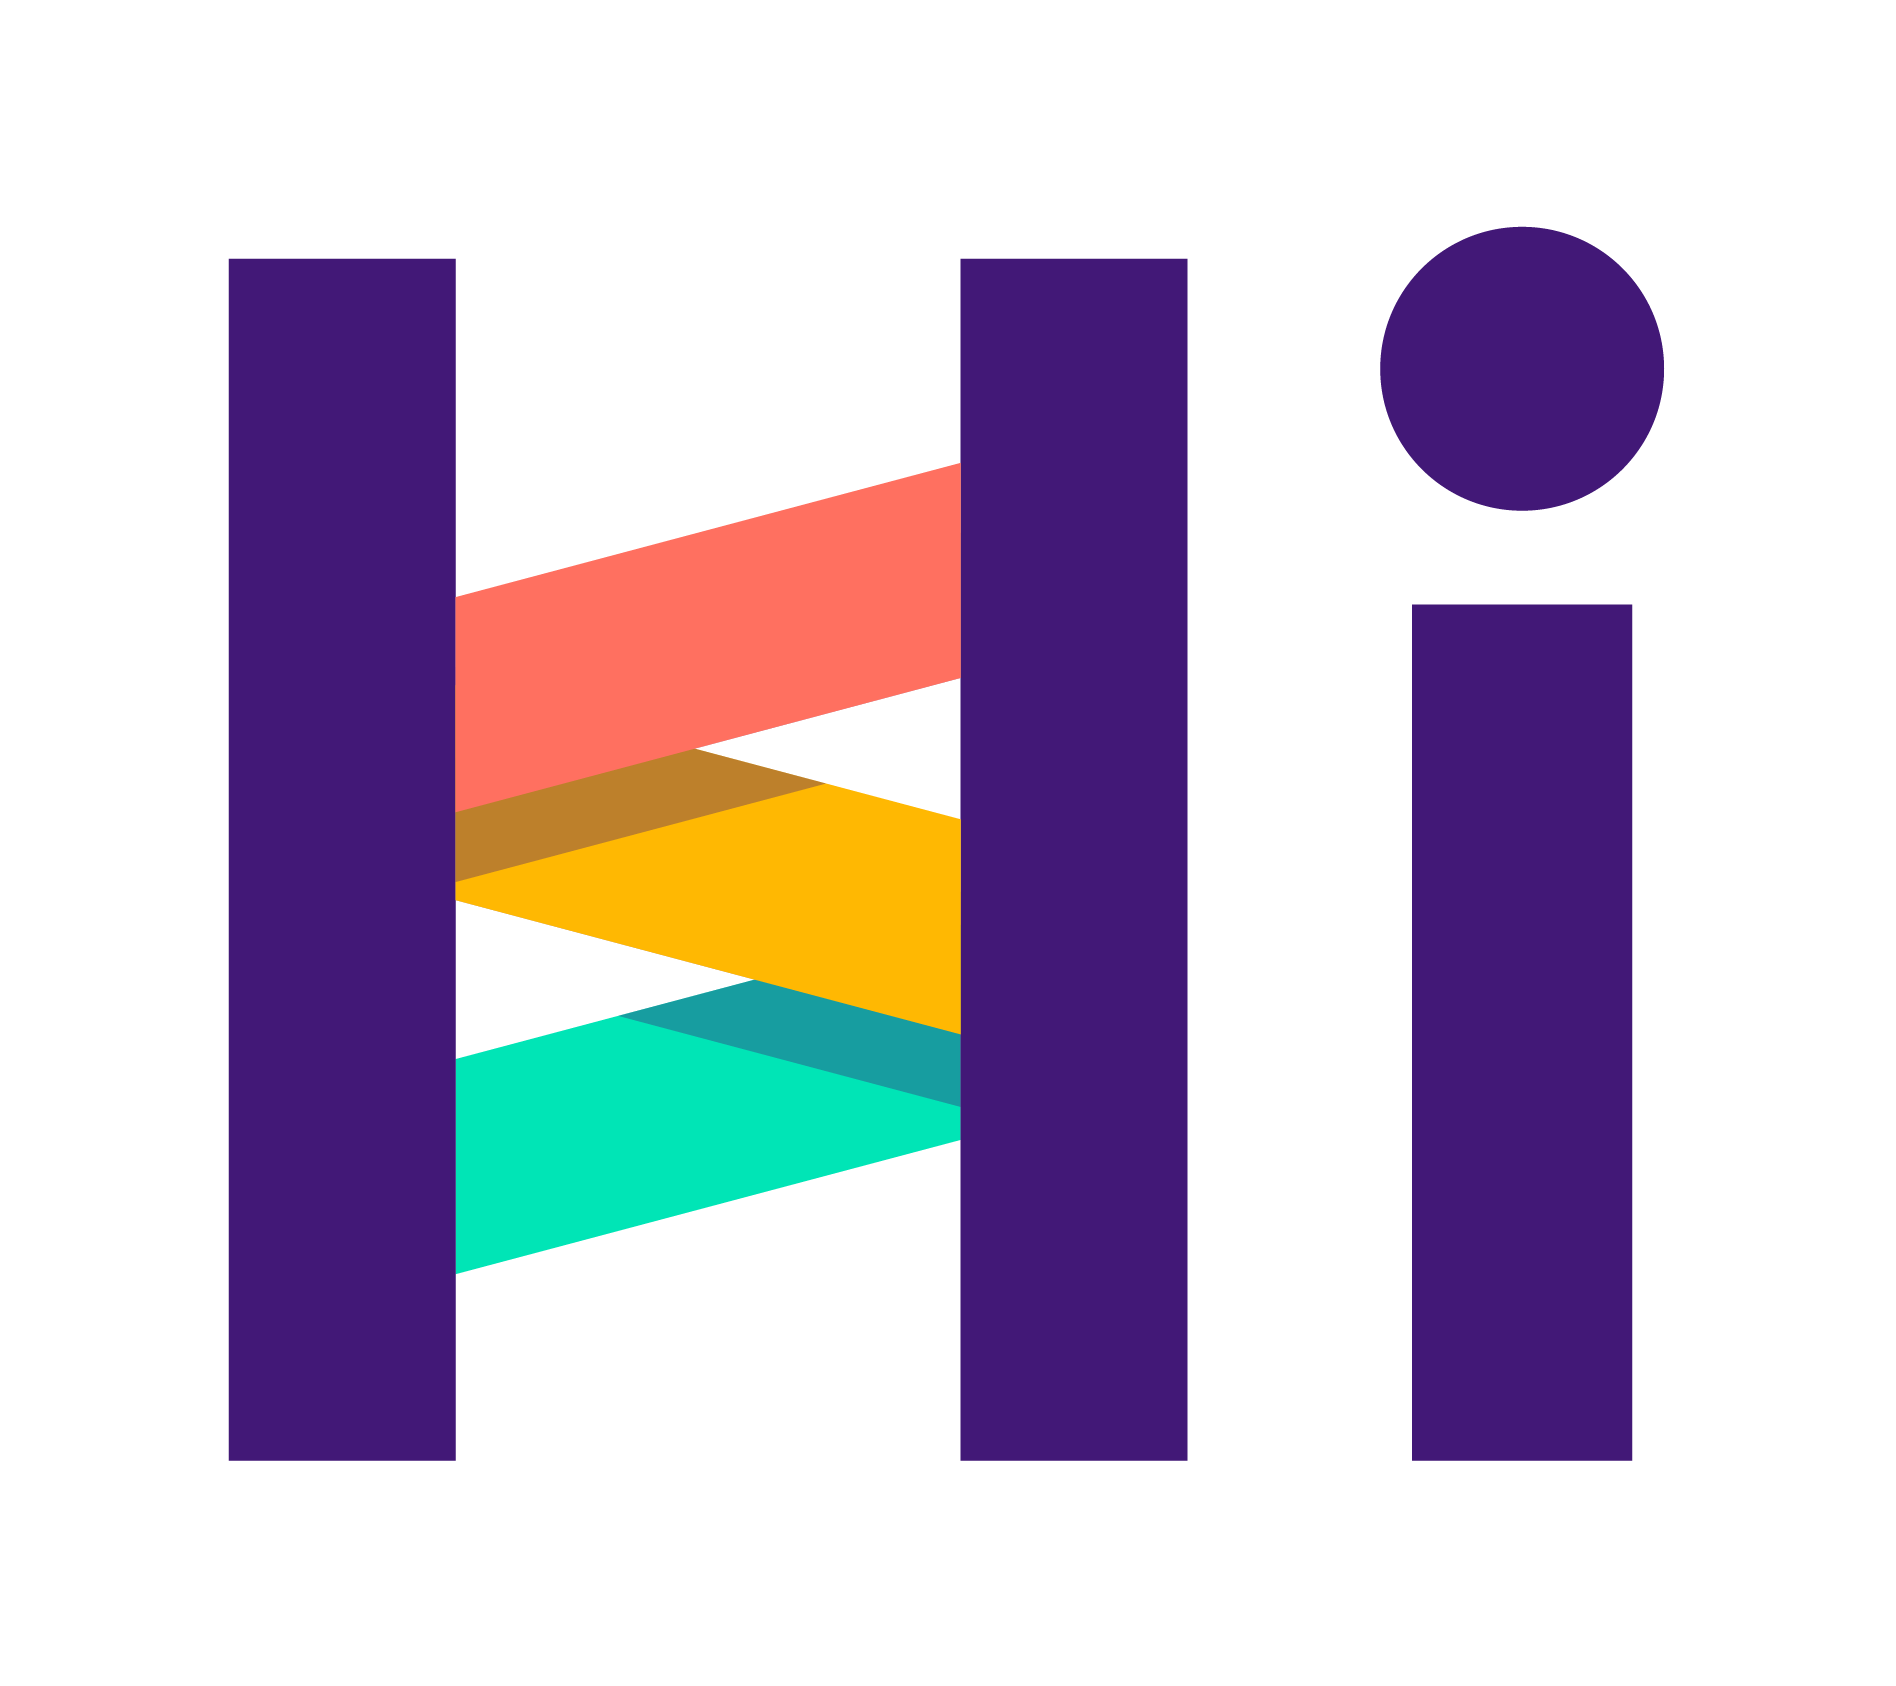

In [ ]:
#@title ## Ranked - Latest History / Parallel Coordinates Analysis - HiPlot
filtered_level_min = 0 #@param {type:"slider", min:0, max:15, step:1}
filtered_level_max = 15 #@param {type:"slider", min:0, max:15, step:1}
filtered_pp_min = 0 #@param {type:"slider", min:0, max:600, step:10}
filtered_pp_max = 600 #@param {type:"slider", min:0, max:600, step:10}
filtered_acc_min = 0 #@param {type:"slider", min:0, max:100, step:1}
filtered_acc_max = 100 #@param {type:"slider", min:0, max:100, step:1}
default_sort_key = "PP" #@param ["PP", "DateJa"]
filtered_latest_is_enable = False #@param {type:"boolean"}
filtered_ranked_is_enable = True #@param {type:"boolean"}

df_history = df_scores[(1==1)
    & (df_scores["Modifiers"] != "NF")
    & (df_scores["Stars"] >= filtered_level_min)
    & (df_scores["Stars"] < filtered_level_max)
    & (df_scores["PP"] >= filtered_pp_min)
    & (df_scores["PP"] < filtered_pp_max)
    & (df_scores["Acc"] >= filtered_acc_min)
    & (df_scores["Acc"] <= filtered_acc_max)]

if filtered_latest_is_enable:
    df_history = df_history[(df_history["Latest"] == 1)]

if filtered_ranked_is_enable:
    df_history = df_history[(df_history['Ranked']==1)]

df_history = df_history[cols_score]

df_history = df_history.reset_index()

df_history["DateJa"] = df_history["DateJa"].astype("str")

exp = hip.Experiment.from_dataframe(df_history)

exp.display_data(hip.Displays.PARALLEL_PLOT).update({
    # Hide some columns in the parallel plot
    "hide": ["uid", "from_uid", "Song", "Cover", "DateJa", "Difficulty"],
    "colorby": ["Stars"],
    # Specify the order for others
    "order": ["PP"],  # Put column time first on the left
})

exp.display_data(hip.Displays.TABLE).update({
    # Don"t display `uid` and `from_uid` columns to the user
    "hide": ["uid", "from_uid"],
    # In the table, order rows by default
    "order_by": [[default_sort_key, "desc"]],
    # Specify the order for columns
    "order": ["pp"],  # Put column time first on the left
})

#exp.to_html()
srcdoc = exp.to_html()  # Store html as string
HTML(srcdoc)

## Ranked - Level Cleared Progress
データの説明については [データについての捕捉](#scrollTo=ckfQPyy2b3Gn)を、  
データの内訳については [clear情報 df_progress 内訳](#scrollTo=uiy6go_3VASb) を参照ください。

In [ ]:
#@title Ranked - Level Cleared Progress
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Cleared Count", "Cleared Rate", "Acc Ranked Count", "Acc Ranked Rate"))

fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["AlreadyCleared"], name="AlreadyCleared", marker_color="#636EFA"),row=1,col=1)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["RecentCleared"], name="RecentCleared", marker_color="#ff4500"),row=1,col=1)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["NF"], name="NoFail", marker_color="#a0a0a0"),row=1,col=1)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["NotCleared"], name="NotCleared", marker_color="#dcdcdc"),row=1,col=1)

fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["AlreadyClearedRate"], name="AlreadyClearedRate", marker_color="#636EFA"),row=1,col=2)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["RecentClearedRate"], name="RecentClearedRate", marker_color="#ff4500"),row=1,col=2)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["NFRate"], name="NoFailRate", marker_color="#a0a0a0"),row=1,col=2)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["NotClearedRate"], name="NotClearedRate",marker_color="#dcdcdc"),row=1,col=2)

fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["SSS"], name="SSS", marker_color="#00ffff"),row=2,col=1)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["SS"], name="SS", marker_color="#ff4500"),row=2,col=1)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["S"], name="S", marker_color="#ffaaff"),row=2,col=1)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["A"], name="A", marker_color="#ffcc66"),row=2,col=1)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["B"], name="B", marker_color="#fffd88"),row=2,col=1)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["Other"], name="Other",marker_color="#dcdcdc"),row=2,col=1)

fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["SSS-Rate"], name="SSS-Rate", marker_color="#00ffff"),row=2,col=2)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["SS-Rate"], name="SS-Rate", marker_color="#ff4500"),row=2,col=2)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["S-Rate"], name="S-Rate", marker_color="#ffaaff"),row=2,col=2)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["A-Rate"], name="A-Rate", marker_color="#ffcc66"),row=2,col=2)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["B-Rate"], name="B-Rate", marker_color="#fffd88"),row=2,col=2)
fig.add_trace(go.Bar(x=df_progress["Level"], y=df_progress["Other-Rate"], name="Other-Rate",marker_color="#dcdcdc"),row=2,col=2)

fig.update_layout(barmode="relative", title_text="Ranked - Level Cleared Progress - {} - {}".format(datetime.now().strftime("%Y.%m.%d"), df_info["name"][0]),width=1000, height=800)
fig.show()

## Ranked - ScatterPlot Analysis

In [ ]:
#@title Ranked - ScatterPlot Analysis
def show_plot(col_x, col_y, size, color, pp_min, pp_max, star_min, star_max, latest):

    def _func_latest(x):
        if  x <= latest:
            return "latest {}day".format(latest)
        else:
            return "old".format(latest)

    df_scores["LatestStr"] = df_scores["Days"].apply(_func_latest).astype("str")
      
    fig2 = px.scatter(df_scores[(df_scores['Ranked']==1)
                       & (df_scores["PP"] >= pp_min)
                       & (df_scores["PP"] <= pp_max)
                       & (df_scores["Stars"] >= star_min)
                       & (df_scores["Stars"] <= star_max)
                                                 #& (df_scores["Months"] <= 1)
                        ], x=col_x, y=col_y, color=color,
                     #animation_frame="MonthsStr", #animation_group="country",
                     size=size, hover_data=["PP","Acc","AccRank","Score","Miss","Bad","Song"],
                     width=800, height=800)

    fig2.update_layout(title="Ranked - ScatterPlot Analysis - {} - {}".format(datetime.now().strftime("%Y.%m.%d"), df_info["name"][0]), title_x=0.5,
                  xaxis_title = "x:{} (markersize:{}, markercolor:{})".format(col_x, size, color), yaxis_title="y:{}".format(col_y)
                  )
                  #font=dict(family="Times",size=18,color="black"))

    fig2.show()

w1 = ToggleButtons(description="X軸:", options=cols_xy)
w2 = ToggleButtons(description="Y軸:", options=cols_xy)
w3 = ToggleButtons(description="Size:", options=cols_xy)
w4 = ToggleButtons(description="Color:", options=cols_cate)

slider_star_min = IntSlider(
    value=0,
    min=0,
    max=15,
    step=1,
    description="Star min:"
)

slider_star_max = IntSlider(
    value=15,
    min=0,
    max=15,
    step=1,
    description="Star max:"
)

slider_pp_min = IntSlider(
    value=0,
    min=0,
    max=600,
    step=10,
    description="PP min:"
)

slider_pp_max = IntSlider(
    value=600,
    min=0,
    max=600,
    step=10,
    description="PP max:"
)

slider_latest = IntSlider(
    value=0,
    min=0,
    max=7,
    step=1,
    description="LatestFilter:"
)

interact(show_plot, col_x=w1, col_y=w2, size=w3, color=w4, pp_min=slider_pp_min, pp_max=slider_pp_max, star_min=slider_star_min, star_max=slider_star_max, latest=slider_latest)

interactive(children=(ToggleButtons(description='X軸:', options=('Stars', 'Acc', 'Rank', 'PP', 'Miss', 'Bad', '…

<function __main__.show_plot(col_x, col_y, size, color, pp_min, pp_max, star_min, star_max, latest)>

## Ranked - Worst/Top Score Analysis (df_worst, df_top, df_worst_top)

In [ ]:
#@title Worst Scores (Playlist Download)
filtered_level_min = 0 #@param {type:"slider", min:0, max:15, step:1}
filtered_level_max = 8 #@param {type:"slider", min:0, max:15, step:1}
filtered_pp_min = 0 #@param {type:"slider", min:0, max:600, step:10}
filtered_pp_max = 600 #@param {type:"slider", min:0, max:600, step:10}
filtered_acc_min = 0 #@param {type:"slider", min:0, max:100, step:1}
filtered_acc_max = 90 #@param {type:"slider", min:0, max:100, step:1}
worst_count =  10#@param {type:"number"}

df_worst = df_scores.head(0)
df_filtered = df_scores[(1==1)
    & (df_scores["Ranked"]==1)
    & (df_scores["Stars"] >= filtered_level_min)
    & (df_scores["Stars"] <= filtered_level_max)
    & (df_scores["PP"] >= filtered_pp_min)
    & (df_scores["PP"] <= filtered_pp_max)
    & (df_scores["Acc"] >= filtered_acc_min)
    & (df_scores["Acc"] <= filtered_acc_max)
]

for level in range(filtered_level_min, filtered_level_max):
    df_worst = df_worst.append(df_filtered[df_filtered["Level"]==level].sort_values("Acc").head(worst_count))#, ignore_index=True)

#@title playlistの出力
download_playlist_isenable = True #@param {type:"boolean"}

if download_playlist_isenable:

    # playlistの出力
    songs = []
    for i, x in df_worst.iterrows():
        songs += [{
            "songName": x["SongName"],
            "levelAuthorName": x["LevelAuthor"],
            "hash": x["Hash"],
            "levelid": f"custom_level_{x['Hash']}",
            "difficulties": [
                {
                    "characteristic": "Standard",
                    "name": x["Difficulty"]
                }
            ]
        }]
    #} for x in df_playlist.iterrows]

    playlist = {
        "playlistTitle": "{}_WorstScores".format(datetime.now().strftime("%Y.%m.%d")),
        "playlistAuthor": "hatopop",
        "songs": songs
        #,"image": img
    }

    song_playlist_path = r"{}/worst_playlist_{}.json".format(data_path, datetime.now().strftime("%Y%m%d"))

    with open(song_playlist_path, "w") as f:
        json.dump(playlist, f)

        files.download(song_playlist_path)

    print("Level {}-{}, Worst{} Playlistを出力しました. 曲数:{}.".format(filtered_level_min, filtered_level_max, worst_count, df_worst["Play"].count()))

df_worst["WorstTop"] = "Worst" 

df_worst[cols_score].sort_values(["Level","Acc"]).style.highlight_null(null_color="red").set_precision(2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Level 0-8, Worst10 Playlistを出力しました. 曲数:33.


,Cover,Song,Level,Stars,Acc,AccRank,FC,Rank,PP,Miss,Bad,Combo,Score,Mode,Difficulty,Play,DailyPlay,Bpm,Duration,Notes,Njs,Bombs,Obstacles,NjsOffset,Upvotes,Downvotes,Ranked,Days,Months
DateJa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-18 15:44:49+09:00,,iLLness LiLin / Chart by Mystikmol [Kaneko Chiharu],4,4.51,86.24,S,-,382,116.24,5,3,296,519752,Standard,Hard,4423,7,280.00,123,659,12.00,4,0,0.00,709,494,True,2,0
2022-04-11 08:06:46+09:00,,Ending / Thaehan [FatBeanzoop],4,4.46,86.69,S,-,1328,117.88,2,1,221,182748,Standard,Expert,2344,9,173.00,32,237,21.00,0,4,-0.60,362,118,True,10,0
2022-04-05 21:27:19+09:00,,BLACK LABEL / C-Show vs. DJ Genki [Yun0],4,4.44,88.93,S,-,914,132.62,6,4,470,756064,Standard,Expert,3500,6,174.00,196,932,19.00,0,42,0.00,1534,158,True,15,0
2022-03-29 13:23:09+09:00,,Naughty little demon (ED version) / Minari [Hoppaw],5,5.22,82.65,S,-,1621,112.90,1,2,52,96661,Standard,ExpertPlus,2561,12,125.00,30,135,19.00,0,2,0.20,197,49,True,22,0
2022-04-13 18:24:28+09:00,,Haachama Channel [Theme Song] feat. Akai Haato / REDALiCE [Light Ai & xtpn],5,5.65,84.48,S,-,2027,132.65,3,1,84,171083,Standard,ExpertPlus,4420,4,130.00,37,228,20.00,0,6,0.30,319,101,True,7,0
2021-09-30 22:01:45+09:00,,Galaxy Collapse / Kurokotei [Skeelie],5,5.32,85.94,S,-,3011,134.89,17,13,216,1692136,Standard,Hard,6436,9,270.00,407,2148,18.00,217,16,-0.50,1781,291,True,202,6
2021-09-20 17:35:06+09:00,,ENDYMION feat. RabbiTon Strings (long edit) / fallen shepherd [Soba`s & Artjoms],5,5.36,85.98,S,-,1267,136.19,16,2,406,1271270,Standard,Expert,1756,7,220.00,260,1615,18.00,26,68,0.14,388,46,True,212,7
2022-03-22 19:49:54+09:00,,Scream Saver VIP / Subtronics [TheWildDash],5,5.68,86.14,S,-,451,145.61,8,1,176,657859,Standard,Expert,744,7,300.00,132,838,19.00,69,264,-1.20,273,93,True,29,0
2021-12-09 18:53:49+09:00,,DONUT HOLE ft. GUMI / Hachi [Kizuflux & Uninstaller],5,5.97,86.52,S,-,1074,156.32,6,7,281,976002,Standard,Expert,2466,7,252.00,205,1234,19.00,20,40,0.75,633,165,True,132,4


In [ ]:
#@title Top Scores (Playlist Download)
filtered_level_min = 0 #@param {type:"slider", min:0, max:15, step:1}
filtered_level_max = 8 #@param {type:"slider", min:0, max:15, step:1}
filtered_pp_min = 0 #@param {type:"slider", min:0, max:600, step:10}
filtered_pp_max = 600 #@param {type:"slider", min:0, max:600, step:10}
filtered_acc_min = 0 #@param {type:"slider", min:0, max:100, step:1}
filtered_acc_max = 100 #@param {type:"slider", min:0, max:100, step:1}
top_count =  3#@param {type:"number"}

df_top = df_scores.head(0)
df_filtered = df_scores[(1==1)
    & (df_scores['Ranked']==1)
    & (df_scores["Stars"] >= filtered_level_min)
    & (df_scores["Stars"] <= filtered_level_max)
    & (df_scores["PP"] >= filtered_pp_min)
    & (df_scores["PP"] <= filtered_pp_max)
    & (df_scores["Acc"] >= filtered_acc_min)
    & (df_scores["Acc"] <= filtered_acc_max)
]

for level in range(filtered_level_min, filtered_level_max):
    df_top = df_top.append(df_filtered[df_filtered["Level"]==level].sort_values("Acc", ascending=False).head(top_count))#, ignore_index=True)

#@title playlistの出力
download_playlist_isenable = True #@param {type:"boolean"}

if download_playlist_isenable:

    # playlistの出力
    songs = []
    for i, x in df_top.iterrows():
        songs += [{
            "songName": x["SongName"],
            "levelAuthorName": x["LevelAuthor"],
            "hash": x["Hash"],
            "levelid": f"custom_level_{x['Hash']}",
            "difficulties": [
                {
                    "characteristic": "Standard",
                    "name": x["Difficulty"]
                }
            ]
        }]
    #} for x in df_playlist.iterrows]

    playlist = {
        "playlistTitle": "{}_TopScores".format(datetime.now().strftime("%Y.%m.%d")),
        "playlistAuthor": "hatopop",
        "songs": songs
        #,"image": img
    }

    song_playlist_path = r"{}/top_playlist_{}.json".format(data_path, datetime.now().strftime("%Y%m%d"))

    with open(song_playlist_path, "w") as f:
        json.dump(playlist, f)

        files.download(song_playlist_path)

    print("Level {}-{}, Top{} Playlistを出力しました. 曲数:{}.".format(filtered_level_min, filtered_level_max, top_count, df_top["Play"].count()))

df_top["WorstTop"] = "Top" 

df_top[cols_score].sort_values(["Level","Acc"]).style.highlight_null(null_color="red").set_precision(2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Level 0-8, Top3 Playlistを出力しました. 曲数:24.


,Cover,Song,Level,Stars,Acc,AccRank,FC,Rank,PP,Miss,Bad,Combo,Score,Mode,Difficulty,Play,DailyPlay,Bpm,Duration,Notes,Njs,Bombs,Obstacles,NjsOffset,Upvotes,Downvotes,Ranked,Days,Months
DateJa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-03 23:31:01+09:00,,G.O.M.D / Sickick [Freeek],0,0.77,97.80,SS,FC,497,51.81,0,0,59,46000,Standard,Easy,1205,3,68.00,131,59,10.00,0,2,0.00,185,40,True,17,0
2022-04-03 23:28:12+09:00,,Small Shock / Toby Fox [Venclaire],0,0.43,99.25,SS,FC,987,57.60,0,0,4,799,Standard,Easy,5921,7,68.00,16,4,8.00,0,0,0.00,501,58,True,17,0
2022-04-03 20:44:53+09:00,,Delightful Introduction / Deathpact [xScaramouche],0,0.31,99.65,SS,FC,691,56.56,0,0,3,573,Standard,Easy,2379,7,145.00,3,3,12.00,0,3,1.00,460,86,True,17,0
2022-04-14 20:22:04+09:00,,Astrogazer - D.J Totto / [D.J Totto],1,1.05,97.14,SS,FC,143,59.44,0,0,164,139531,Standard,Easy,572,0,154.00,112,164,10.00,0,0,0.00,100,67,True,6,0
2022-04-06 20:54:33+09:00,,Black Emperor / Chart by Mystikmol [Chroma],1,1.08,97.28,SS,FC,280,62.72,0,0,78,62759,Standard,Easy,1309,1,180.00,124,78,10.00,0,0,0.00,921,271,True,14,0
2022-04-03 23:37:03+09:00,,Crying for Rain / Minami [squeaksies],1,1.23,97.34,SS,FC,780,72.29,0,0,312,272359,Standard,Easy,2313,6,137.00,252,312,10.00,0,0,0.00,4307,287,True,17,0
2022-04-11 16:11:37+09:00,,HE4VEN ~tengoku e youkoso~ / kamome sano electric orchestra [Mystikmol],2,2.04,96.25,SS,FC,277,99.19,0,0,237,202885,Standard,Normal,1162,2,256.00,124,237,15.00,22,11,0.00,682,201,True,9,0
2022-04-14 18:16:56+09:00,,fractal / FELT [Kival Evan],2,2.00,96.36,SS,FC,66,98.88,0,0,115,94963,Standard,Normal,292,2,178.00,97,115,9.00,0,102,0.25,388,89,True,6,0
2022-04-18 17:25:04+09:00,,I / Chroma [Mystikmol & Moriik],2,2.29,96.49,SS,FC,94,115.49,0,0,434,378260,Standard,Normal,891,4,225.00,123,434,16.00,2,42,-1.00,480,114,True,2,0


In [ ]:
#@title WorstとTop結合
df_worst_top = df_worst
df_worst_top = df_worst_top.append(df_top)#filtered[df_filtered["Level"]==level].sort_values("Acc", ascending=False).head(top_count))#, ignore_index=True)

In [ ]:
#@title Worst/Top ScatterPlot Analysis
def show_plot(col_x, col_y, size, color):
    
    fig = px.scatter(df_worst_top
                        , x=col_x, y=col_y, color=color,
                     size=size, hover_data=["PP","Acc","AccRank","Score","Miss","Bad","Song"],
                     width=800, height=800)

    fig.update_layout(title="Ranked - Worst/Top - ScatterPlot Analysis - {} - {}".format(datetime.now().strftime("%Y.%m.%d"), df_info["name"][0]), title_x=0.5,
                  xaxis_title = "x:{} (markersize:{}, markercolor:{})".format(col_x, size, color), yaxis_title="y:{}".format(col_y)
                  )
                  #font=dict(family="Times",size=18,color="black"))

    fig.show()

w1 = ToggleButtons(description="X軸:", options=cols_xy)
w2 = ToggleButtons(description="Y軸:", options=cols_xy)
w3 = ToggleButtons(description="Size:", options=cols_xy)
w4 = ToggleButtons(description="Color:", options=cols_cate_wt)

interact(show_plot, col_x=w1, col_y=w2, size=w3, color=w4)

interactive(children=(ToggleButtons(description='X軸:', options=('Stars', 'Acc', 'Rank', 'PP', 'Miss', 'Bad', '…

<function __main__.show_plot(col_x, col_y, size, color)>